# Bayesian Neural Network (BNN) Model for Stress Prediction with Porosity Effects

---

## Overview

A **Bayesian Neural Network (BNN)** is a probabilistic model that combines the flexibility of neural networks with the principled uncertainty quantification of Bayesian inference. In this work, we use a BNN to model the complex, nonlinear relationship between process parameters and post-yield stress, especially in the presence of microstructural variations such as **porosity**.

---

## Problem Setup

Given inputs:

$$
\mathbf{x}_i = \left( T_i, \log \dot{\varepsilon}_i, \varepsilon_i, p_i \right)
$$

where:

- ($T$): temperature (K)  
- ($\dot{\varepsilon}$): strain rate (1/s)  
- ($\varepsilon$): true strain  
- ($p$): porosity (volume fraction or grouped indicator)

We aim to predict:

$$
\sigma_i \sim \mathcal{N}(\mu(\mathbf{x}_i), \sigma^2)
$$

Where:
- ($\mu(\mathbf{x}_i)$) is the **BNN mean output**
- ($\sigma^2$) is the homoscedastic noise variance (learned)

---

## BNN Architecture

We define the predictive mean function as a fully connected neural network:

$$
\mu(\mathbf{x}) = f(\mathbf{x}; \mathbf{W}, \mathbf{b})
$$

### Example: 1 hidden layer BNN

$$
\begin{align*}
\mathbf{h} &= \tanh(\mathbf{x} \cdot \mathbf{W}_1 + \mathbf{b}_1) \\
\mu(\mathbf{x}) &= \mathbf{h} \cdot \mathbf{W}_2 + \mathbf{b}_2
\end{align*}
$$

---

## Prior Over Weights

Each weight and bias parameter in the network is treated as a random variable:

$$
w_{jk}, b_j \sim \mathcal{N}(0, \tau^2)
$$

- A typical choice is ($\tau = 1.0$)
- This imposes a Gaussian prior on function space and regularizes complexity

The full posterior is then:

$$
p(\mathbf{W}, \mathbf{b}, \sigma \mid \mathcal{D}) \propto p(\mathcal{D} \mid \mathbf{W}, \mathbf{b}, \sigma) \cdot p(\mathbf{W}, \mathbf{b}, \sigma)
$$

Where:
- ($\mathcal{D} = \{ (\mathbf{x}_i, \sigma_i) \}$)

---

## Likelihood

The stress observations are assumed to follow a Normal likelihood centered at the BNN output:

$$
\sigma_i \sim \mathcal{N}(\mu(\mathbf{x}_i), \sigma^2)
$$

---

## Porosity Bias via Learned Representation

Instead of modeling porosity via parameter offsets (as in hierarchical Z-A), we directly **input porosity as a feature**:

- Either as a scalar (e.g., 0.15) or one-hot encoding if grouped (e.g., [0, 1] for group 2)
- The neural network **automatically learns** how porosity shifts the response surface

This corresponds to:

$$
f(\mathbf{x}; \text{porosity}) = \text{NN}(T, \log \dot{\varepsilon}, \varepsilon, p)
$$

---

## Posterior Inference

We use **Markov Chain Monte Carlo (MCMC)**, specifically NUTS (No-U-Turn Sampler), to sample from the joint posterior over network weights and predictive noise:

$$
\left\{ \mathbf{W}^{(s)}, \mathbf{b}^{(s)}, \sigma^{(s)} \right\}_{s=1}^S \sim p(\cdot \mid \mathcal{D})
$$

Posterior predictive distribution:

$$
p(\hat{\sigma} \mid \mathbf{x}_\ast) = \int \mathcal{N}(f(\mathbf{x}_\ast; \mathbf{W}, \mathbf{b}), \sigma^2) \, p(\mathbf{W}, \mathbf{b}, \sigma \mid \mathcal{D}) \, d\mathbf{W}
$$

In practice, approximated via Monte Carlo average over ($S$) posterior samples.

---

## Modeling Strategy

1. Preprocess input features (log strain rate, normalize inputs and stress)
2. Define a BNN with small architecture (e.g., 1–2 hidden layers)
3. Set Gaussian priors over weights and biases
4. Infer posterior via NUTS or SVI (stochastic variational inference)
5. Predict stress with uncertainty via `Predictive` sampling


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import jax
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro import sample
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
df = pd.read_csv("../data/full_data.csv")  

# Clip values to avoid log(0) or negative power
df["strainrate"] = df["strainrate"].clip(lower=1e-6)
df["strain"] = df["strain"].clip(lower=1e-6)

features = ["T", "strainrate", "strain", "porosity"]
target = "stress"

scaler_X = StandardScaler()
scaler_y = StandardScaler()

df[features] = scaler_X.fit_transform(df[features])
df[target] = scaler_y.fit_transform(df[[target]])

X = jnp.array(df[features].values)
y = jnp.array(df[target].values)

In [3]:
# Define BNN model
def bnn_model(X, y=None):
    hidden_dim = 32

    # Layer 1 weights and biases
    w1 = numpyro.sample("w1", dist.Normal(0, 1).expand([X.shape[1], hidden_dim]))
    b1 = numpyro.sample("b1", dist.Normal(0, 1).expand([hidden_dim]))

    # Output layer
    w2 = numpyro.sample("w2", dist.Normal(0, 1).expand([hidden_dim]))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))

    sigma = numpyro.sample("sigma", dist.Exponential(1.0))

    # Forward pass
    hidden = jnp.tanh(jnp.dot(X, w1) + b1)
    mean = jnp.dot(hidden, w2) + b2

    numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)

In [4]:
# MCMC sampling
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(bnn_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1200)
mcmc.run(rng_key, X=X, y=y)
mcmc.print_summary()

sample: 100%|█| 1700/1700 [20:33<00:00,  1.38it/s, 1023 steps of size 5.42e-04. 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]      2.08      0.18      2.04      1.83      2.37      3.42      1.96
     b1[1]      1.02      0.14      0.95      0.85      1.24      3.06      2.27
     b1[2]      4.97      0.17      4.98      4.75      5.33      8.02      1.22
     b1[3]     -4.84      0.78     -4.58     -6.17     -3.82      3.50      1.78
     b1[4]     -3.21      0.18     -3.17     -3.47     -2.97      2.88      2.75
     b1[5]     -1.90      0.07     -1.89     -2.01     -1.76      4.09      1.68
     b1[6]      0.74      0.07      0.73      0.64      0.84      5.62      1.14
     b1[7]      2.20      0.05      2.21      2.10      2.26      3.67      1.93
     b1[8]     14.92      0.19     14.92     14.61     15.23      4.52      2.37
     b1[9]      7.56      0.27      7.47      7.19      7.97      3.65      1.80
    b1[10]     -3.07      0.24     -3.06     -3.48     -2.78      4.43      1.79
    b1[11]      0.53      0

In [7]:
def predict_stress_curve_bnn(porosity_value, T_value=400, rate_value=2000, strain_step=0.005):
    """
    Generate posterior predictive stress-strain curve using BNN.
    Returns median prediction and 95% credible interval.

    Parameters
    ----------
    porosity_value : float
        Porosity value to condition prediction (e.g., 26 or 36).
    T_value : float
        Temperature (Kelvin) for prediction.
    rate_value : float
        Strain rate (1/s) for prediction.
    strain_step : float
        Step size for the strain axis (default: 0.005).

    Returns
    -------
    strain_range : np.ndarray
        Array of strain values.
    stress_median : np.ndarray
        Posterior median stress predictions.
    stress_lower : np.ndarray
        2.5 percentile of stress (lower bound of 95% CI).
    stress_upper : np.ndarray
        97.5 percentile of stress (upper bound of 95% CI).
    """
    strain_range = np.arange(0.01, 0.25, strain_step)

    test_df = pd.DataFrame({
        "T": T_value,
        "strainrate": rate_value,
        "strain": strain_range,
        "porosity": porosity_value
    })

    X_test_scaled = scaler_X.transform(test_df)
    X_test_jnp = jnp.array(X_test_scaled)

    predictive = Predictive(bnn_model, mcmc.get_samples(), return_sites=["obs"])
    rng_key_pred = random.PRNGKey(1)
    preds = predictive(rng_key_pred, X=X_test_jnp)["obs"]  # shape: (n_samples, n_points)

    stress_median = scaler_y.inverse_transform(jnp.median(preds, axis=0).reshape(-1, 1)).flatten()
    stress_lower = scaler_y.inverse_transform(jnp.percentile(preds, 2.5, axis=0).reshape(-1, 1)).flatten()
    stress_upper = scaler_y.inverse_transform(jnp.percentile(preds, 97.5, axis=0).reshape(-1, 1)).flatten()

    # Add (0, 0) as physical starting point
    strain_range = np.insert(strain_range, 0, 0.0)
    stress_median = np.insert(stress_median, 0, 0.0)
    stress_lower = np.insert(stress_lower, 0, 0.0)
    stress_upper = np.insert(stress_upper, 0, 0.0)

    return strain_range, stress_median, stress_lower, stress_upper

# Plotting function
def plot_bnn_curve(porosity_value, T_value=400, rate_value=2000):
    """
    Plot BNN posterior predictive stress-strain curve with 95% credible interval.

    Parameters
    ----------
    porosity_value : float
        Porosity condition for the test curve.
    T_value : float
        Temperature value (default: 400).
    rate_value : float
        Strain rate (default: 2000).
    """
    strain_range, stress_median, stress_lower, stress_upper = predict_stress_curve_bnn(
        porosity_value=porosity_value,
        T_value=T_value,
        rate_value=rate_value
    )

    plt.figure(figsize=(7, 5))
    plt.plot(strain_range, stress_median, label="BNN Median Prediction", color="blue")
    plt.fill_between(strain_range, stress_lower, stress_upper,
                     alpha=0.3, label="95% Credible Interval", color="blue")
    plt.xlabel("Strain")
    plt.ylabel("Stress (MPa)")
    plt.title(f"Posterior Predictive Stress-Strain Curve (Porosity = {porosity_value})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

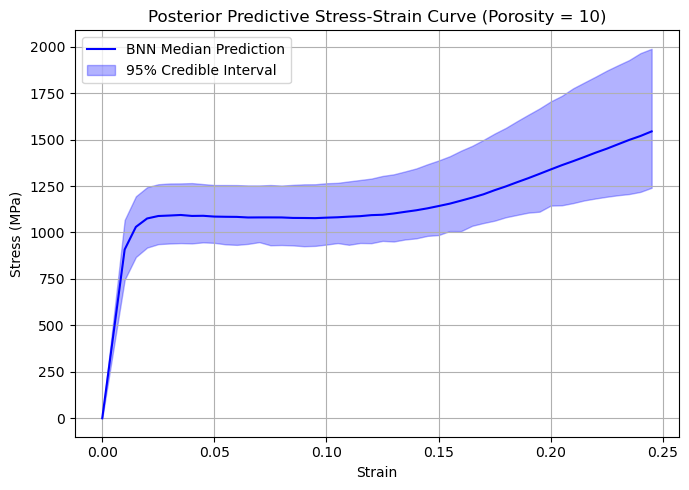

In [21]:
# Example usage
plot_bnn_curve(porosity_value=10, T_value=300, rate_value=3000)